# Recurrent Neural Networks for Variable-Length Sequence Regression using PyTorch

Recurrent Neural Networks (RNNs) have gained significant attention in various machine learning tasks, especially when dealing with sequential data such as time series, natural language processing, and speech recognition. One of the challenges in working with sequential data is that the lengths of input sequences may vary from one sample to another. In such cases, padding techniques are often employed to ensure uniformity in input sizes, allowing the data to be processed efficiently by neural networks.

In this notebook, we explore the application of Recurrent Neural Networks, specifically Long Short-Term Memory (LSTM) networks, for a regression task where the length of input sequences differs across samples. The task at hand involves predicting the frequency of a noisy signal. We'll demonstrate how to preprocess the data, handle variable-length sequences using padding, build an LSTM model architecture, train the model, and evaluate its performance.

By the end of this notebook, you will have a clear understanding of how to leverage RNNs and LSTM networks in PyTorch for regression tasks with variable-length input sequences.


#### Create the data

The `generate_data` function below is designed to create synthetic data for a regression task involving variable-length sequences. It takes parameters such as the number of samples to generate, the minimum and maximum lengths for each sequence, the frequency range for the sine wave signals, and the scale of the noise to be added to the signals.

For each sample, the function randomly selects a sequence length within the specified range. It also randomly selects a frequency within the given frequency range and generates a phase value uniformly between 0 and 2π. Using these parameters, it generates a sine wave signal with the chosen frequency and phase.

To introduce variability and mimic real-world scenarios, the function adds Gaussian noise to the signal scaled by the specified noise scale. The length of the sequence, the chosen frequency, and the noisy signal are then appended to separate lists representing the dataset.

The function returns three lists: the noisy signals, the corresponding frequencies, and the lengths of each sequence.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_data(num_samples, min_seq_length, max_seq_length, freq_range=(1, 10), noise_scale=0.3):
    # Initialize empty lists to store data
    data = []         # List to store noisy signals
    seq_lengths = []  # List to store lengths of sequences
    freqs = []        # List to store frequencies
    
    # Generate data for each sample
    for _ in range(num_samples):
        # Randomly select a sequence length within the specified range
        seq_length = np.random.randint(min_seq_length, max_seq_length + 1)
        # Randomly select a frequency within the given frequency range
        freq = np.random.uniform(*freq_range)
        # Randomly select a phase value uniformly between 0 and 2π
        phase = np.random.uniform(0, 2*np.pi)
        # Generate a sequence of evenly spaced values from 0 to 2π
        x = np.linspace(0, 2*np.pi, seq_length)
        # Generate a sine wave signal with the chosen frequency and phase
        signal = np.sin(freq * x + phase)
        # Generate Gaussian noise scaled by the specified noise scale
        noise = noise_scale * np.random.randn(seq_length)
        # Add the noise to the signal to create a noisy signal
        noisy_signal = signal + noise
        # Append the noisy signal, sequence length, and frequency to the respective lists
        data.append(noisy_signal)
        seq_lengths.append(seq_length)
        freqs.append(freq)
    
    # Return the lists containing the generated data
    return data, freqs, seq_lengths






### Defining the model
The model we will use is defined in the class `FrequencyPredictor`.

### Constructor
- The constructor `__init__` initializes the model architecture. It takes three parameters:
    - `input_size`: The number of features in the input.
    - `hidden_size`: The number of features in the hidden state of the LSTM.
    - `output_size`: The number of output features.
- It defines an LSTM encoder with `num_layers=1` layers, `input_size` input features, and `hidden_size` hidden features. The `batch_first=True` argument indicates that the input and output tensors are provided as `(batch_size, seq_length, input_size)`.
- Additionally, it creates a fully connected layer (`fc`) with `hidden_size` input features and `output_size` output features.

### Forward Method
- The `forward` method defines the forward pass of the model. It takes two parameters:
    - `x`: The input tensor, which represents the sequences. It is expected to be of shape `(batch_size, seq_length, input_size)`.
    - `seq_lengths`: A list containing the lengths of each sequence in the batch.
- Inside the method, `nn.utils.rnn.pack_padded_sequence` is used to pack the padded input sequences (`x`) along with their lengths (`seq_lengths`). This step is necessary to handle variable-length sequences efficiently. When training RNNs, it can be challenging to batch variable-length sequences. For instance, if you have a batch of sequences with lengths [4,6,8,5,4,3,7,8], you would typically pad all the sequences to the length of the longest sequence (in this case, 8), resulting in 8 sequences of length 8. This would require 64 computations (8x8), but you only need to do 45 computations because the total length of all sequences is 45. PackedSequence helps to optimize this process. Internally, a PackedSequence is a tuple of two lists. One list contains the elements of the sequences, interleaved by time steps. The other list contains the size of each sequence or the batch size at each step. This information is useful for recovering the actual sequences and informing the RNN of the batch size at each time step.
- The packed sequences are then passed through the LSTM encoder (`self.encoder`), which returns the hidden state of the last time step.
- Finally, the hidden state of the last time step is passed through the fully connected layer (`self.fc`), and the output is returned.

This model architecture allows for the prediction of frequencies from sequences of variable lengths using LSTM networks.


In [12]:
class FrequencyPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FrequencyPredictor, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, seq_lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, seq_lengths, batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.encoder(packed)
        output = self.fc(hidden[-1])
        return output


### Define hyper-parameters and generate the training data

#### Parameters:
- `num_samples`: Specifies the number of synthetic samples to generate.
- `min_seq_length`: Defines the minimum length of each sequence.
- `max_seq_length`: Specifies the maximum length of each sequence.
- `input_size`: Indicates the size of the input features.
- `hidden_size`: Specifies the size of the hidden state in the model.
- `output_size`: Indicates the size of the output features.
- `num_epochs`: Specifies the number of training epochs.
- `batch_size`: Defines the batch size used during training.
- `learning_rate`: Specifies the learning rate for the optimizer.

### Synthetic Dataset Generation:
- The code calls the function `generate_data` to create synthetic data. This function generates `num_samples` sequences, where each sequence has a random length between `min_seq_length` and `max_seq_length`. It also generates frequencies and noisy signals for each sequence.
- The noisy signals are padded to ensure uniformity in sequence lengths using `nn.utils.rnn.pad_sequence`. This is a utility function provided by PyTorch's nn module specifically designed for handling sequences of variable lengths by padding them to the same length within a batch. The function takes a list of tensors as input. Each tensor represents a sequence and can have different lenghts. The function pads the sequences with zeros (or a specified padding value) to make them all the same length. The function returns a single tensor representing the padded sequences.

### Plotting:
- The code then creates a 2x2 grid of subplots using `plt.subplots`.
- Each subplot displays a sample sequence along with its corresponding frequency.
- The `X_padded` tensor contains the padded sequences, while `Y` contains the corresponding frequencies.
- In the loop, each subplot is filled with the amplitude values of the corresponding sequence, and the title indicates the frequency associated with that sequence.

This code provides a visual representation of the synthetic dataset, showcasing the relationship between sequences of varying lengths and their corresponding frequencies.


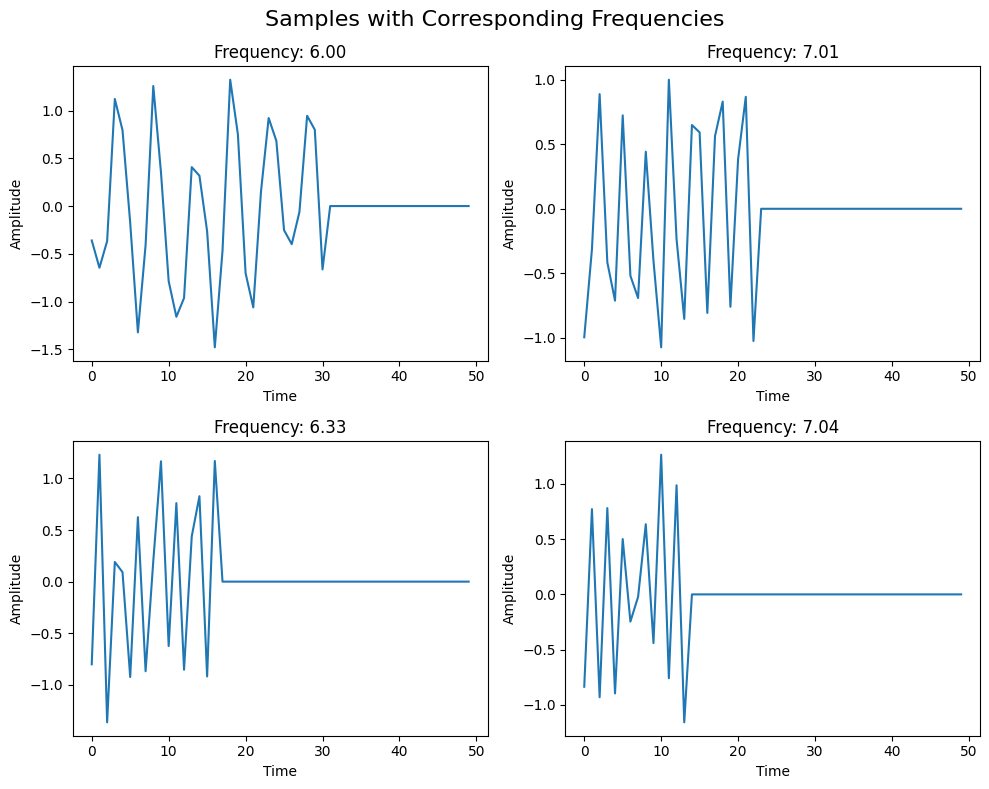

In [13]:
# Define parameters for the synthetic dataset generation and model training.
num_samples = 6000  # Number of synthetic samples to generate
min_seq_length = 10  # Minimum length of each sequence
max_seq_length = 50  # Maximum length of each sequence
input_size = 1  # Number of features in the input
hidden_size = 24  # Number of features in the hidden state of the model
output_size = 1  # Number of output features
num_epochs = 20  # Number of training epochs
batch_size = 32  # Batch size used during training
learning_rate = 0.05  # Learning rate for the optimizer

# Generate synthetic data using the defined parameters
data, freqs, seq_lengths = generate_data(num_samples, min_seq_length, max_seq_length)

# Pad the sequences in the dataset to ensure uniformity in sequence lengths within each batch
X_padded = nn.utils.rnn.pad_sequence([torch.tensor(sample, dtype=torch.float32).unsqueeze(1) for sample in data], batch_first=True)
# Convert the frequencies into a tensor for use as the target variable during training
Y = torch.tensor(freqs, dtype=torch.float32).unsqueeze(1)

# Create subplots
# Initialize a figure with subplots to visualize the synthetic data
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Samples with Corresponding Frequencies', fontsize=16)

# Iterate over the subplots and plot each sample sequence along with its corresponding frequency
for i, ax in enumerate(axs.flat):
    sample = X_padded[i].squeeze().detach().numpy()  # Extract the sample sequence and convert it to a NumPy array
    freq = Y[i].item()  # Extract the corresponding frequency for the sample
    ax.plot(sample)  # Plot the sample sequence
    ax.set_title(f'Frequency: {freq:.2f}')  # Set the title of the subplot to display the frequency
    ax.set_xlabel('Time')  # Set the x-axis label
    ax.set_ylabel('Amplitude')  # Set the y-axis label

plt.tight_layout()  # Adjust the layout of the subplots for better spacing
plt.show()  # Display the figure with subplots



# Train the model
Below we define the training cycle to train this model.

Epoch [1/20], Loss: 8.3484
Epoch [2/20], Loss: 2.7475
Epoch [3/20], Loss: 2.3902
Epoch [4/20], Loss: 1.4765
Epoch [5/20], Loss: 1.0295
Epoch [6/20], Loss: 0.8933
Epoch [7/20], Loss: 0.6473
Epoch [8/20], Loss: 0.5975
Epoch [9/20], Loss: 0.5486
Epoch [10/20], Loss: 0.6178
Epoch [11/20], Loss: 0.6549
Epoch [12/20], Loss: 0.6267
Epoch [13/20], Loss: 0.5424
Epoch [14/20], Loss: 0.4766
Epoch [15/20], Loss: 0.4770
Epoch [16/20], Loss: 0.3925
Epoch [17/20], Loss: 0.3508
Epoch [18/20], Loss: 0.3140
Epoch [19/20], Loss: 0.2878
Epoch [20/20], Loss: 0.2675


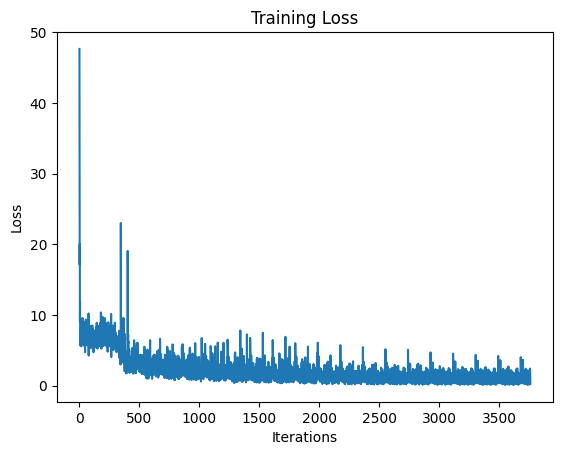

In [14]:
# Define model, loss function, and optimizer
# Instantiate the FrequencyPredictor model, define the loss function, and specify the optimizer for training.
model = FrequencyPredictor(input_size, hidden_size, output_size)  # Create an instance of the FrequencyPredictor model
criterion = nn.MSELoss()  # Define the Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1, nesterov=True)  # Specify the optimizer with stochastic gradient descent (SGD)

# Training loop
# Perform training iterations over the specified number of epochs
losses = []  # Initialize a list to store the losses for each iteration
for epoch in range(num_epochs):  # Iterate over the epochs
    for i in range(0, len(X_padded), batch_size):  # Iterate over the data in batches
        optimizer.zero_grad()  # Clear the gradients from the previous iteration
        batch_X, batch_Y, batch_lengths = X_padded[i:i+batch_size], Y[i:i+batch_size], seq_lengths[i:i+batch_size]  # Extract a batch of input data, target data, and sequence lengths
        output = model(batch_X, batch_lengths)  # Perform a forward pass through the model to obtain predictions
        loss = criterion(output, batch_Y)  # Calculate the loss between the predictions and the target values
        loss.backward()  # Perform backpropagation to compute gradients
        optimizer.step()  # Update the model parameters using the optimizer
        losses.append(loss.item())  # Append the loss value to the list of losses for monitoring

    # Print epoch information
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the loss curve
# Visualize the training loss over iterations to monitor the training progress
plt.plot(losses)  # Plot the losses
plt.xlabel('Iterations')  # Set the x-axis label
plt.ylabel('Loss')  # Set the y-axis label
plt.title('Training Loss')  # Set the title of the plot
plt.show()  # Display the plot



### Evaluate the model
Here we will evaluate the model by visualizing the predictions against the target values using a scatter plot.

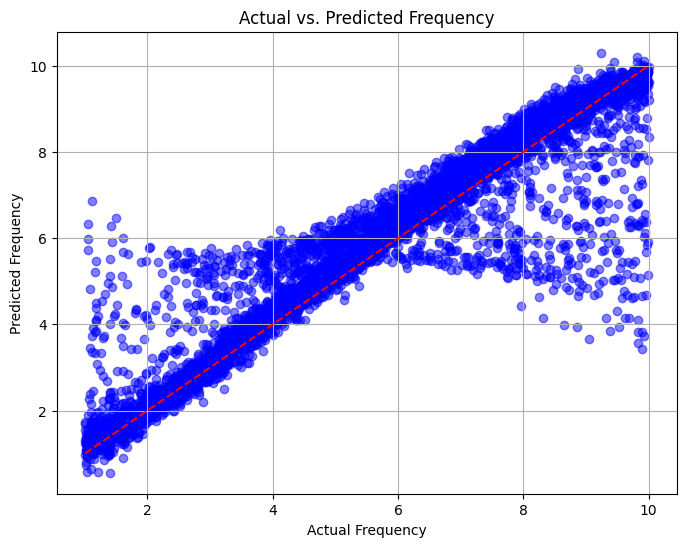

In [15]:
def test_model(model, data, freqs):
    actual_freqs = []
    predicted_freqs = []

    for sample, actual_freq in zip(data, freqs):
        signal = torch.tensor(sample, dtype=torch.float32).unsqueeze(0).unsqueeze(2)  # Add batch and channel dimensions
        predicted_freq = model(signal, [len(sample)])  # Provide sequence length for padded data
        actual_freqs.append(actual_freq)
        predicted_freqs.append(predicted_freq.item())

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_freqs, predicted_freqs, color='blue', alpha=0.5)
    plt.plot([min(actual_freqs), max(actual_freqs)], [min(actual_freqs), max(actual_freqs)], color='red', linestyle='--')
    plt.xlabel('Actual Frequency')
    plt.ylabel('Predicted Frequency')
    plt.title('Actual vs. Predicted Frequency')
    plt.grid(True)
    plt.show()

# Testing the model
test_model(model, data, freqs)
